In [1]:
# data manipulation 
import numpy as np
import pandas as pd



from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from fbprophet import Prophet
%matplotlib inline
pd.plotting.register_matplotlib_converters()

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
import prep
#import model


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


#### Acquire and prep
consolidate all the csv files, delete the nutrition related data. 

In [2]:
df= acquire.get_df()
df.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


In [3]:
df= prep.prep_df()
target_vars=['Steps']
df.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


#### Split Data

In [4]:
train, test= prep.test_train_split(df, .66)
print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 148
Testing Observations: 77


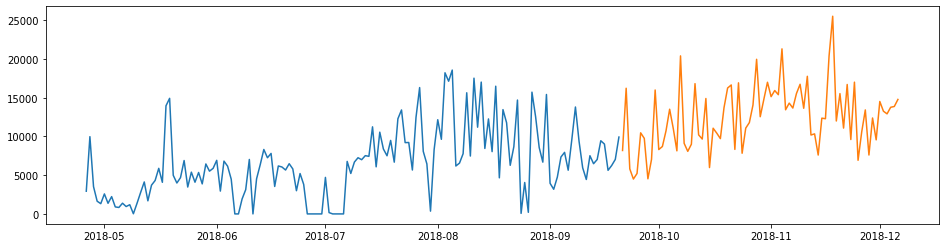

In [5]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

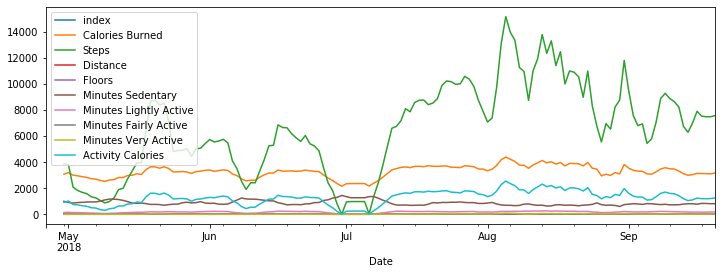

In [6]:
#Moving Average
train.rolling(5).mean().plot(figsize=(12, 4))
plt.show()

### Last observed value

In [7]:
yhat = pd.DataFrame(test[target_vars])
for var in target_vars:
    yhat[var] = int(train[var][-1:])
yhat.head()

,Steps
Date,
2018-09-21,9920
2018-09-22,9920
2018-09-23,9920
2018-09-24,9920
2018-09-25,9920


In [8]:
for var in target_vars:
    print(var, ":", yhat[var].min() == yhat[var].max())

Steps : True


In [9]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()
    
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


Steps -- MSE: 23685924.27 RMSE: 4866.82


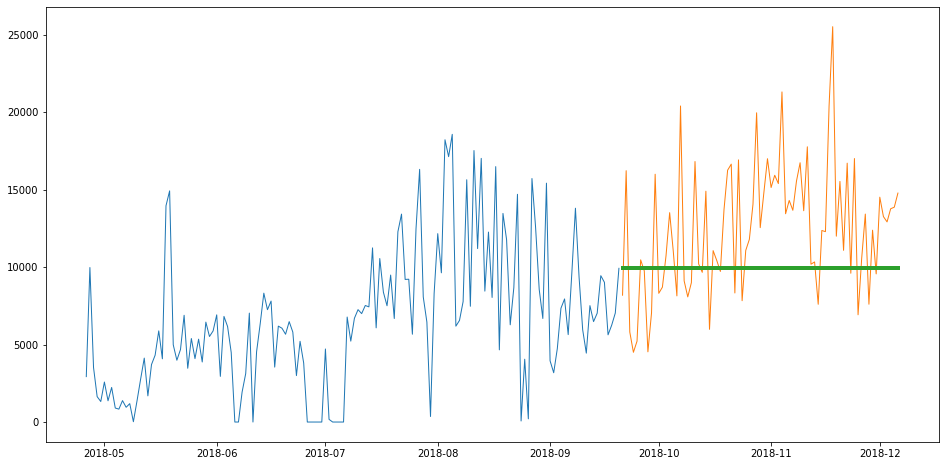

In [10]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

In [11]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_vars=target_vars, train = train, test = test)

#### Simple Average

In [12]:
for var in target_vars:
    yhat[var] = train[var].mean()

Steps -- MSE: 53133261.42 RMSE: 7289.26


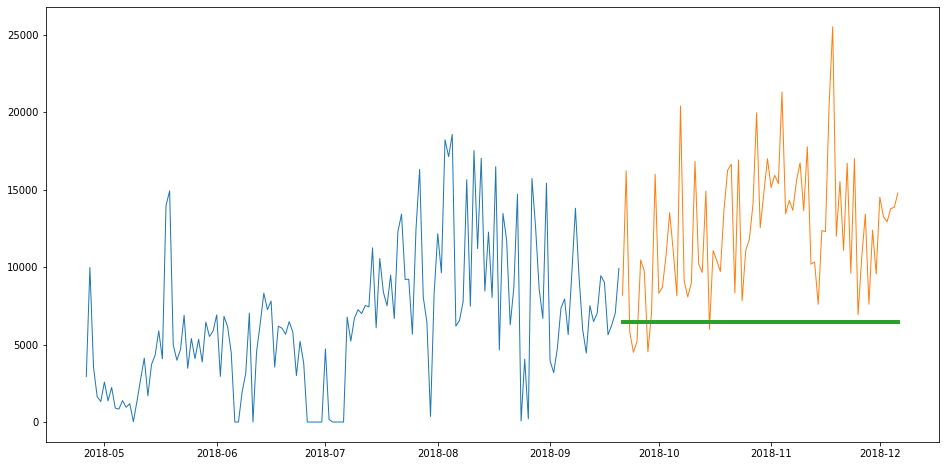

In [13]:
plot_and_eval(target_vars, train = train, test = test)

#### Moving Average

In [14]:
periods = 12
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]

Steps -- MSE: 43590772.51 RMSE: 6602.33


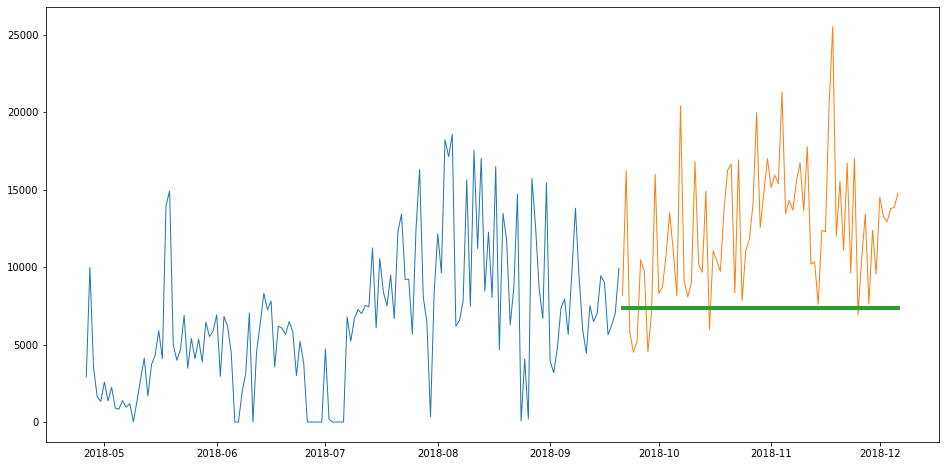

In [15]:
plot_and_eval(target_vars, train = train, test = test)

### Holt's Linear Trend

Steps 



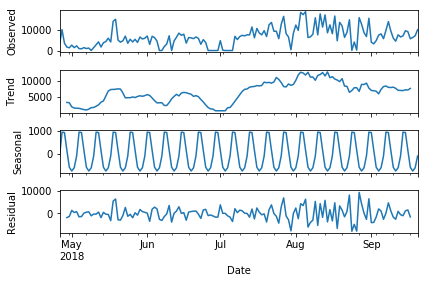

In [16]:
import statsmodels.api as sm

for var in target_vars:
    print(var,'\n')
    _ = sm.tsa.seasonal_decompose(train[var].resample('D').mean()).plot()
    plt.show()

### Fit Basic Holt's Linear Trend Model

Steps -- MSE: 31151561.26 RMSE: 5581.36


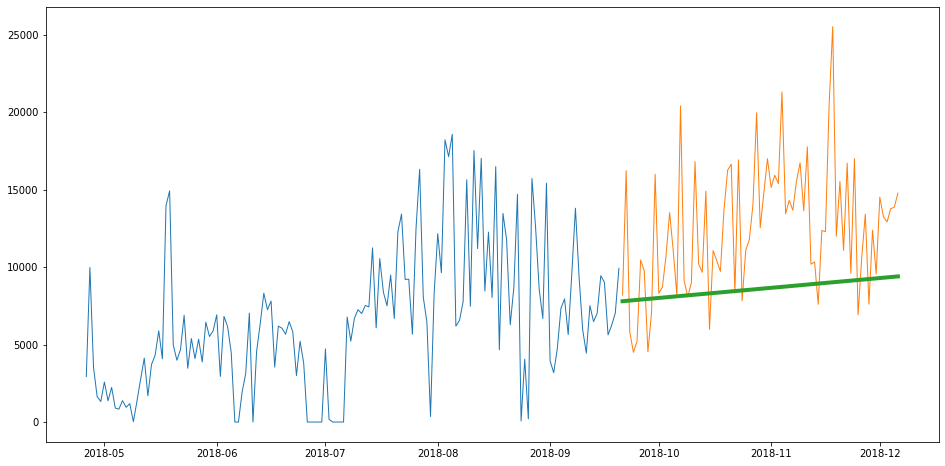

In [17]:
from statsmodels.tsa.api import Holt

for var in target_vars:
    model = Holt(train[var]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=target_vars, train = train, test = test)

In [18]:
#FB Prophet

In [19]:
def prep_steps_data(df: pd.DataFrame) -> pd.DataFrame:
    return (df.assign(ds=pd.to_datetime(df.Date)).sort_values('ds')
            .assign(y=df.Steps)\
            .groupby(['ds'])['y'].sum().reset_index().set_index('ds'))

In [20]:
#Organize data for FB prophet
df1=prep_steps_data(df)

In [21]:
df1.head()

,y
ds,
2018-04-26,2931.0
2018-04-27,9971.0
2018-04-28,3521.0
2018-04-29,1639.0
2018-04-30,1323.0


In [22]:
#Split df1
def split_Steps_data(df1, train_prop=.66): 
    train_size = int(len(df1) * train_prop)
    train1, test1 = df1[0:train_size].reset_index(), df1[train_size:len(df)].reset_index()
    return train1, test1

In [23]:
train1, test1 = split_Steps_data(df1, train_prop=.66)

In [24]:
print("train1:", train1.shape, "test1:", test1.shape)
train1.head()

train1: (148, 2) test1: (77, 2)


,ds,y
0,2018-04-26,2931.0
1,2018-04-27,9971.0
2,2018-04-28,3521.0
3,2018-04-29,1639.0
4,2018-04-30,1323.0


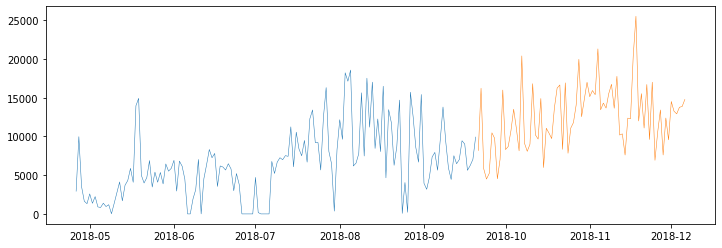

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(train1.set_index('ds'), linewidth=0.5)
plt.plot(test1.set_index('ds'), linewidth=0.5)
plt.show()

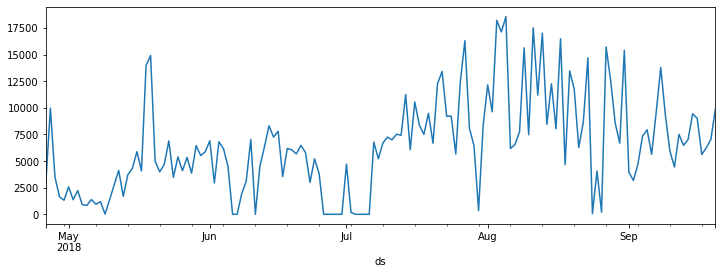

In [26]:
#Daily
train1.set_index('ds').resample('D').sum().plot(figsize=(12, 4), legend=False)
plt.show()

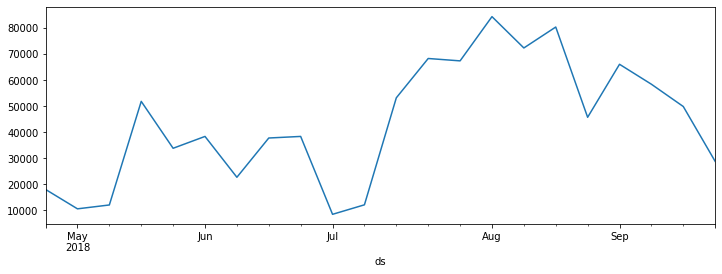

In [27]:
#Weekly
train1.set_index('ds').resample('W').sum().plot(figsize=(12, 4), legend=False)
plt.show()

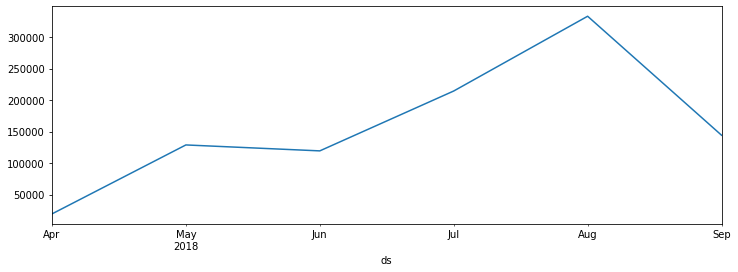

In [28]:
#Monthly
train1.set_index('ds').resample('MS').sum().plot(figsize=(12, 4), legend=False)
plt.show()

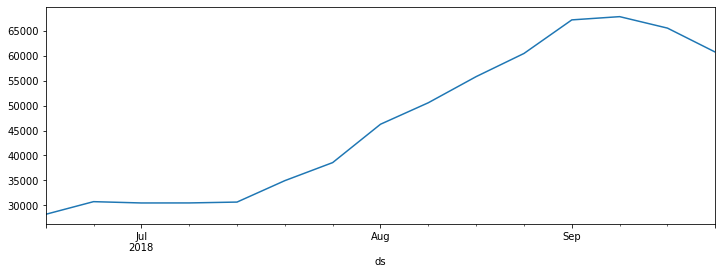

In [29]:
#Average Sales
#Moving average of weekly total Steps
train_weekly_rolling_mean = train1.set_index('ds').resample('W').sum().rolling(8, min_periods=8).mean().dropna()
train_weekly_rolling_mean.plot(figsize=(12, 4), legend=False)
plt.show()

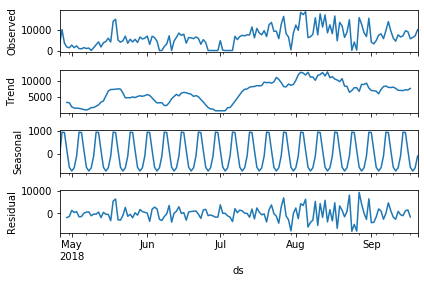

In [30]:
#Seasonal Decomposition

sm.tsa.seasonal_decompose(train1.set_index('ds').resample('D').mean()).plot()
plt.show()

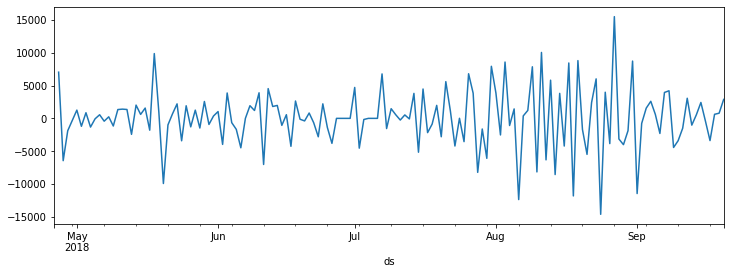

In [31]:
#Weeky Seasonality
train1.set_index('ds').diff(periods=1).plot(figsize=(12, 4), legend=False)
plt.show()

### Model

Fit Model: Prophet

In [39]:
import fbprophet
df1.head()
df1=pd.DataFrame(df1)
df1.head()

,y
ds,
2018-04-26,2931.0
2018-04-27,9971.0
2018-04-28,3521.0
2018-04-29,1639.0
2018-04-30,1323.0


In [41]:
df1=df1.reset_index()

In [42]:
#Fit the model
m = Prophet()
m.fit(df1)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
#Predictions
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
585,2019-12-02
586,2019-12-03
587,2019-12-04
588,2019-12-05
589,2019-12-06


The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [74]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,yhat,yhat_lower,yhat_upper
0,2018-04-26,2884.367404,-2535.687511,7927.898782
1,2018-04-27,3161.522356,-1498.819858,8511.260289
2,2018-04-28,3857.711984,-1148.219985,8781.846294
3,2018-04-29,4210.015927,-1025.331545,9214.677208
4,2018-04-30,1580.162792,-3338.498411,6529.769708


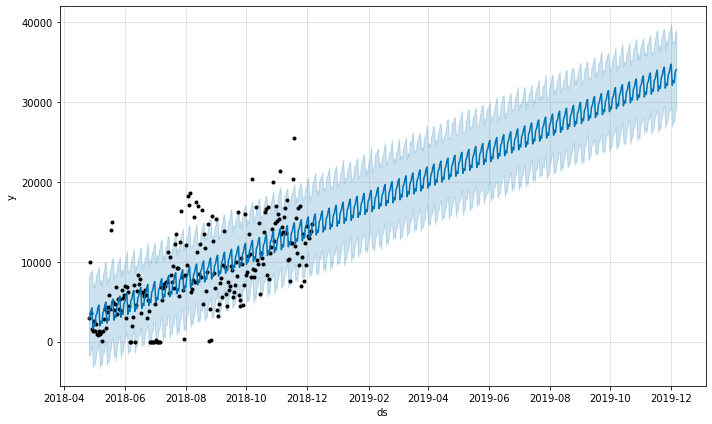

In [73]:
fig1 = m.plot(forecast)


In [49]:
df1.tail()

,ds,y
220,2018-12-02,13257.0
221,2018-12-03,12915.0
222,2018-12-04,13763.0
223,2018-12-05,13865.0
224,2018-12-06,14774.0


In [65]:
#Predicting 14 days into the future

future1 = m.make_future_dataframe(periods=14)
forecast1 = m.predict(future1)
forecast1.tail(14)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
225,2018-12-07,14493.792069,9890.090018,20003.107977,14493.792069,14493.792069,436.895474,436.895474,436.895474,436.895474,436.895474,436.895474,0.0,0.0,0.0,14930.687543
226,2018-12-08,14546.332971,10705.177177,20475.787071,14546.332971,14546.332971,1080.544166,1080.544166,1080.544166,1080.544166,1080.544166,1080.544166,0.0,0.0,0.0,15626.877137
227,2018-12-09,14598.873873,10824.718344,21031.271759,14598.873872,14598.873874,1380.307172,1380.307172,1380.307172,1380.307172,1380.307172,1380.307172,0.0,0.0,0.0,15979.181046
228,2018-12-10,14651.414776,8600.449977,18162.323729,14651.414773,14651.414778,-1302.086898,-1302.086898,-1302.086898,-1302.086898,-1302.086898,-1302.086898,0.0,0.0,0.0,13349.327877
229,2018-12-11,14703.955678,9213.203388,18760.091576,14703.955672,14703.955682,-748.415319,-748.415319,-748.415319,-748.415319,-748.415319,-748.415319,0.0,0.0,0.0,13955.540359
230,2018-12-12,14756.496580,8923.825021,18554.407136,14756.496571,14756.496587,-1059.526053,-1059.526053,-1059.526053,-1059.526053,-1059.526053,-1059.526053,0.0,0.0,0.0,13696.970527
231,2018-12-13,14809.037482,10390.231745,19806.366105,14809.037470,14809.037492,212.281458,212.281458,212.281458,212.281458,212.281458,212.281458,0.0,0.0,0.0,15021.318940
232,2018-12-14,14861.578384,10717.759251,20136.357632,14861.578369,14861.578397,436.895474,436.895474,436.895474,436.895474,436.895474,436.895474,0.0,0.0,0.0,15298.473858
233,2018-12-15,14914.119286,10697.226819,21229.602341,14914.119269,14914.119302,1080.544166,1080.544166,1080.544166,1080.544166,1080.544166,1080.544166,0.0,0.0,0.0,15994.663452
234,2018-12-16,14966.660189,11293.097303,21177.473133,14966.660166,14966.660207,1380.307172,1380.307172,1380.307172,1380.307172,1380.307172,1380.307172,0.0,0.0,0.0,16346.967361


In [71]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper',]].tail(14)

,ds,yhat,yhat_lower,yhat_upper
225,2018-12-07,14930.687543,9890.090018,20003.107977
226,2018-12-08,15626.877137,10705.177177,20475.787071
227,2018-12-09,15979.181046,10824.718344,21031.271759
228,2018-12-10,13349.327877,8600.449977,18162.323729
229,2018-12-11,13955.540359,9213.203388,18760.091576
230,2018-12-12,13696.970527,8923.825021,18554.407136
231,2018-12-13,15021.318940,10390.231745,19806.366105
232,2018-12-14,15298.473858,10717.759251,20136.357632
233,2018-12-15,15994.663452,10697.226819,21229.602341
234,2018-12-16,16346.967361,11293.097303,21177.473133


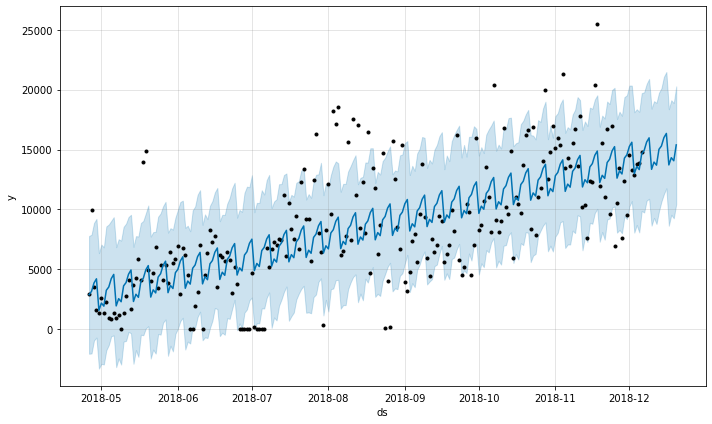

In [61]:
m.plot(forecast1);

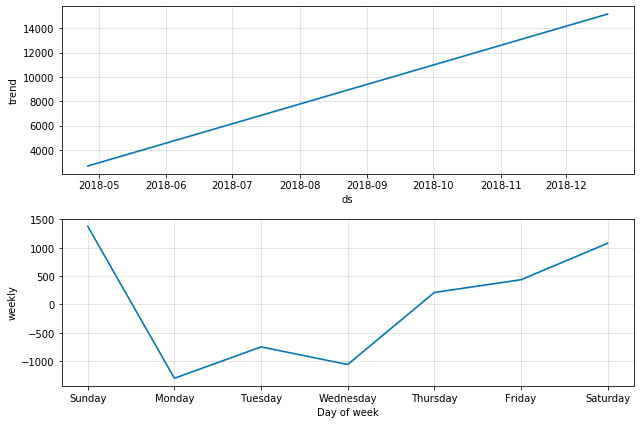

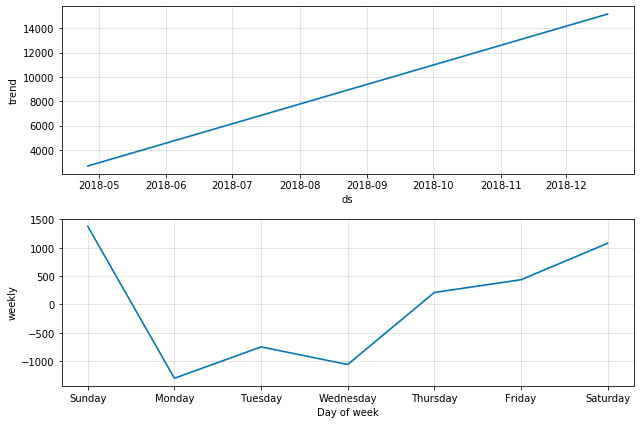

In [63]:
m.plot_components(forecast1)